# Inicializace

In [1]:
from collections import deque               # Ukladani stavu
from __future__ import division             # Deleni realnych cisel (kvuli verzi Pythonu 2.6)
import sys                                  # Pro navazani knihovny Open AI Gym
import numpy as np                          # Knihovna pro operace s maticemi
sys.path.append('/home/xbucha02/libraries') # Adresa knihovny Open AI Gym
import gym                                  # Knihovna Open AI Gym
#from gym import wrappers                    # Pomucka na nahravani
env = gym.make('MountainCar-v0')            # Konkretni hra z Open AI Gym
#env = wrappers.Monitor(env, '/home/lachubcz/tmp/cartpole-experiment-1', force=True) #Nahravani zaznamu
#gpuMemoryUsage=0.8                            # Vyuziti pameti GPU
import tensorflow as tf                     # Knihovna TensorFlow pro sdileni GPU
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = gpuMemoryUsage
#set_session(tf.Session(config=config))
import random

# Parametry
observetime = 500                          # Pocet framu kazde hry
startEpsilon = 1.0                         # Pravdepodobnost konani nahodneho tahu na zacatku
endEpsilon = 0.1                           # Pravdepodobnost konani nahodneho tahu na konci
currentEpsilon = startEpsilon              # Soucasna pravdepodobnost konani nahodneho tahu
epsilonDiminution = 0.995                  # Hodnota snizovani epsilonu
gamma = 0.95                               # Discount faktor
minibatchSize = 32                         # Velikost minibatche
episodes = 5000                            # Pocet epizod
actionCount = env.action_space.n           # Pocet vstupu do prostredi
stateSize = env.observation_space.shape[0] # Pocet vystupu z prostredi
learningRate = 0.001                       # Learning rate
memorySize = 10000                         # Velikost Replay memory

# Model NN

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics

def getDQN(actionCount,stateSize):
    net = Sequential()
    net.add(Dense(24, activation="relu", input_dim=stateSize))
    net.add(Dense(24, activation="relu"))
    net.add(Dense(actionCount, activation="linear"))
    
    net.summary()
    
    net.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    
    return net

Using TensorFlow backend.


# Algoritmus DQN

In [3]:
net = getDQN(actionCount, stateSize)
observation = env.reset()                    # Reset prostredi
memory = deque(maxlen=memorySize)

global scores
scores = []
global episodes
episodesList = []

for eps in range (episodes):
    
    #D = deque() #vyprazdneni D
    state = env.reset()
    state = np.reshape(state, [1, stateSize])
    #env.render()

    #q = 0
    for t in range(observetime):
        #if q == 0:
            
        #else:
        #    if q == 4:
        #        q = 0
        #    else:
        #        q = q + 1
        if np.random.rand() <= currentEpsilon:
            action = np.random.randint(0, actionCount, size=1)[0]
        else:

            Q = net.predict(state)

            action = np.argmax(Q)

        observation_new, reward, done, info = env.step(int(action))

        next_state = np.reshape(observation_new, [1, stateSize])

        memory.append((state, action, reward, next_state, done))

        state = next_state         # Update state

        if done:
            print("Episode: {}/{}, epsilon: {}, score: {}".format(eps, episodes, currentEpsilon, t))
            scores.append(t)
            episodesList.append(eps)
            break
            
    if eps > 0:
        if len(memory) < minibatchSize:
            continue
        minibatch = random.sample(memory, minibatchSize) #z D vybere pocet mb_size samplu

        for i in range(0, minibatchSize):

            stateMb = minibatch[i][0]
            actionMb = minibatch[i][1]
            rewardMb = minibatch[i][2]
            state_newMb = minibatch[i][3]
            doneMb = minibatch[i][4]

            Q_sa = net.predict(state_newMb) #[0]

            if doneMb:
                targetMb = rewardMb
            else:
                targetMb = rewardMb + gamma * np.max(Q_sa)

            target_f = net.predict(stateMb)

            target_f[0][actionMb] = targetMb

            net.fit(stateMb, target_f, epochs=1, verbose=0)

        if currentEpsilon > endEpsilon:
            currentEpsilon = currentEpsilon * epsilonDiminution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                72        
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 75        
Total params: 747.0
Trainable params: 747
Non-trainable params: 0.0
_________________________________________________________________
Episode: 0/5000, epsilon: 1.0, score: 199
Episode: 1/5000, epsilon: 1.0, score: 199
Episode: 2/5000, epsilon: 0.995, score: 199
Episode: 3/5000, epsilon: 0.990025, score: 199
Episode: 4/5000, epsilon: 0.985074875, score: 199
Episode: 5/5000, epsilon: 0.9801495006250001, score: 199
Episode: 6/5000, epsilon: 0.9752487531218751, score: 199
Episode: 7/5000, epsilon: 0.9703725093562657, score: 199
Episode:

Episode: 130/5000, epsilon: 0.5238143793828016, score: 199
Episode: 131/5000, epsilon: 0.5211953074858876, score: 199
Episode: 132/5000, epsilon: 0.5185893309484582, score: 199
Episode: 133/5000, epsilon: 0.5159963842937159, score: 199
Episode: 134/5000, epsilon: 0.5134164023722473, score: 199
Episode: 135/5000, epsilon: 0.510849320360386, score: 199
Episode: 136/5000, epsilon: 0.5082950737585841, score: 199
Episode: 137/5000, epsilon: 0.5057535983897912, score: 199
Episode: 138/5000, epsilon: 0.5032248303978422, score: 199
Episode: 139/5000, epsilon: 0.500708706245853, score: 199
Episode: 140/5000, epsilon: 0.4982051627146237, score: 199
Episode: 141/5000, epsilon: 0.49571413690105054, score: 199
Episode: 142/5000, epsilon: 0.4932355662165453, score: 199
Episode: 143/5000, epsilon: 0.4907693883854626, score: 199
Episode: 144/5000, epsilon: 0.4883155414435353, score: 199
Episode: 145/5000, epsilon: 0.4858739637363176, score: 199
Episode: 146/5000, epsilon: 0.483444593917636, score: 199

Episode: 269/5000, epsilon: 0.2609670281126685, score: 199
Episode: 270/5000, epsilon: 0.25966219297210513, score: 199
Episode: 271/5000, epsilon: 0.2583638820072446, score: 199
Episode: 272/5000, epsilon: 0.2570720625972084, score: 199
Episode: 273/5000, epsilon: 0.25578670228422234, score: 199
Episode: 274/5000, epsilon: 0.25450776877280124, score: 199
Episode: 275/5000, epsilon: 0.2532352299289372, score: 199
Episode: 276/5000, epsilon: 0.2519690537792925, score: 199
Episode: 277/5000, epsilon: 0.2507092085103961, score: 199
Episode: 278/5000, epsilon: 0.2494556624678441, score: 199
Episode: 279/5000, epsilon: 0.24820838415550486, score: 199
Episode: 280/5000, epsilon: 0.24696734223472733, score: 199
Episode: 281/5000, epsilon: 0.2457325055235537, score: 199
Episode: 282/5000, epsilon: 0.24450384299593592, score: 199
Episode: 283/5000, epsilon: 0.24328132378095624, score: 199
Episode: 284/5000, epsilon: 0.24206491716205145, score: 199
Episode: 285/5000, epsilon: 0.2408545925762412, 

Episode: 407/5000, epsilon: 0.13066846301911936, score: 199
Episode: 408/5000, epsilon: 0.13001512070402377, score: 199
Episode: 409/5000, epsilon: 0.12936504510050365, score: 199
Episode: 410/5000, epsilon: 0.12871821987500112, score: 199
Episode: 411/5000, epsilon: 0.12807462877562611, score: 199
Episode: 412/5000, epsilon: 0.12743425563174798, score: 199
Episode: 413/5000, epsilon: 0.12679708435358925, score: 199
Episode: 414/5000, epsilon: 0.1261630989318213, score: 199
Episode: 415/5000, epsilon: 0.1255322834371622, score: 199
Episode: 416/5000, epsilon: 0.12490462201997637, score: 199
Episode: 417/5000, epsilon: 0.1242800989098765, score: 199
Episode: 418/5000, epsilon: 0.12365869841532712, score: 199
Episode: 419/5000, epsilon: 0.12304040492325048, score: 199
Episode: 420/5000, epsilon: 0.12242520289863423, score: 199
Episode: 421/5000, epsilon: 0.12181307688414106, score: 199
Episode: 422/5000, epsilon: 0.12120401149972035, score: 199
Episode: 423/5000, epsilon: 0.1205979914422

Episode: 546/5000, epsilon: 0.0996820918179746, score: 199
Episode: 547/5000, epsilon: 0.0996820918179746, score: 199
Episode: 548/5000, epsilon: 0.0996820918179746, score: 199
Episode: 549/5000, epsilon: 0.0996820918179746, score: 199
Episode: 550/5000, epsilon: 0.0996820918179746, score: 199
Episode: 551/5000, epsilon: 0.0996820918179746, score: 199
Episode: 552/5000, epsilon: 0.0996820918179746, score: 199
Episode: 553/5000, epsilon: 0.0996820918179746, score: 199
Episode: 554/5000, epsilon: 0.0996820918179746, score: 199
Episode: 555/5000, epsilon: 0.0996820918179746, score: 199
Episode: 556/5000, epsilon: 0.0996820918179746, score: 199
Episode: 557/5000, epsilon: 0.0996820918179746, score: 199
Episode: 558/5000, epsilon: 0.0996820918179746, score: 199
Episode: 559/5000, epsilon: 0.0996820918179746, score: 199
Episode: 560/5000, epsilon: 0.0996820918179746, score: 199
Episode: 561/5000, epsilon: 0.0996820918179746, score: 199
Episode: 562/5000, epsilon: 0.0996820918179746, score: 1

Episode: 685/5000, epsilon: 0.0996820918179746, score: 199
Episode: 686/5000, epsilon: 0.0996820918179746, score: 199
Episode: 687/5000, epsilon: 0.0996820918179746, score: 199
Episode: 688/5000, epsilon: 0.0996820918179746, score: 199
Episode: 689/5000, epsilon: 0.0996820918179746, score: 199
Episode: 690/5000, epsilon: 0.0996820918179746, score: 199
Episode: 691/5000, epsilon: 0.0996820918179746, score: 199
Episode: 692/5000, epsilon: 0.0996820918179746, score: 199
Episode: 693/5000, epsilon: 0.0996820918179746, score: 199
Episode: 694/5000, epsilon: 0.0996820918179746, score: 199
Episode: 695/5000, epsilon: 0.0996820918179746, score: 199
Episode: 696/5000, epsilon: 0.0996820918179746, score: 199
Episode: 697/5000, epsilon: 0.0996820918179746, score: 199
Episode: 698/5000, epsilon: 0.0996820918179746, score: 199
Episode: 699/5000, epsilon: 0.0996820918179746, score: 199
Episode: 700/5000, epsilon: 0.0996820918179746, score: 199
Episode: 701/5000, epsilon: 0.0996820918179746, score: 1

Episode: 824/5000, epsilon: 0.0996820918179746, score: 199
Episode: 825/5000, epsilon: 0.0996820918179746, score: 199
Episode: 826/5000, epsilon: 0.0996820918179746, score: 199
Episode: 827/5000, epsilon: 0.0996820918179746, score: 199
Episode: 828/5000, epsilon: 0.0996820918179746, score: 199
Episode: 829/5000, epsilon: 0.0996820918179746, score: 199
Episode: 830/5000, epsilon: 0.0996820918179746, score: 199
Episode: 831/5000, epsilon: 0.0996820918179746, score: 199
Episode: 832/5000, epsilon: 0.0996820918179746, score: 199
Episode: 833/5000, epsilon: 0.0996820918179746, score: 199
Episode: 834/5000, epsilon: 0.0996820918179746, score: 199
Episode: 835/5000, epsilon: 0.0996820918179746, score: 199
Episode: 836/5000, epsilon: 0.0996820918179746, score: 199
Episode: 837/5000, epsilon: 0.0996820918179746, score: 199
Episode: 838/5000, epsilon: 0.0996820918179746, score: 199
Episode: 839/5000, epsilon: 0.0996820918179746, score: 199
Episode: 840/5000, epsilon: 0.0996820918179746, score: 1

Episode: 963/5000, epsilon: 0.0996820918179746, score: 199
Episode: 964/5000, epsilon: 0.0996820918179746, score: 199
Episode: 965/5000, epsilon: 0.0996820918179746, score: 199
Episode: 966/5000, epsilon: 0.0996820918179746, score: 199
Episode: 967/5000, epsilon: 0.0996820918179746, score: 199
Episode: 968/5000, epsilon: 0.0996820918179746, score: 199
Episode: 969/5000, epsilon: 0.0996820918179746, score: 199
Episode: 970/5000, epsilon: 0.0996820918179746, score: 199
Episode: 971/5000, epsilon: 0.0996820918179746, score: 199
Episode: 972/5000, epsilon: 0.0996820918179746, score: 199
Episode: 973/5000, epsilon: 0.0996820918179746, score: 199
Episode: 974/5000, epsilon: 0.0996820918179746, score: 199
Episode: 975/5000, epsilon: 0.0996820918179746, score: 199
Episode: 976/5000, epsilon: 0.0996820918179746, score: 199
Episode: 977/5000, epsilon: 0.0996820918179746, score: 199
Episode: 978/5000, epsilon: 0.0996820918179746, score: 199
Episode: 979/5000, epsilon: 0.0996820918179746, score: 1

Episode: 1101/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1102/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1103/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1104/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1105/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1106/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1107/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1108/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1109/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1110/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1111/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1112/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1113/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1114/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1115/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1116/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1117/5000, epsilon: 0.099682091

Episode: 1238/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1239/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1240/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1241/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1242/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1243/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1244/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1245/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1246/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1247/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1248/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1249/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1250/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1251/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1252/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1253/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1254/5000, epsilon: 0.099682091

Episode: 1375/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1376/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1377/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1378/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1379/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1380/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1381/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1382/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1383/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1384/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1385/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1386/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1387/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1388/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1389/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1390/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1391/5000, epsilon: 0.099682091

Episode: 1512/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1513/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1514/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1515/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1516/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1517/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1518/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1519/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1520/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1521/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1522/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1523/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1524/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1525/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1526/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1527/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1528/5000, epsilon: 0.099682091

Episode: 1649/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1650/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1651/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1652/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1653/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1654/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1655/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1656/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1657/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1658/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1659/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1660/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1661/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1662/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1663/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1664/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1665/5000, epsilon: 0.099682091

Episode: 1786/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1787/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1788/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1789/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1790/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1791/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1792/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1793/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1794/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1795/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1796/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1797/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1798/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1799/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1800/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1801/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1802/5000, epsilon: 0.099682091

Episode: 1923/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1924/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1925/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1926/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1927/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1928/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1929/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1930/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1931/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1932/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1933/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1934/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1935/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1936/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1937/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1938/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1939/5000, epsilon: 0.099682091

Episode: 2060/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2061/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2062/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2063/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2064/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2065/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2066/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2067/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2068/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2069/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2070/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2071/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2072/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2073/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2074/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2075/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2076/5000, epsilon: 0.099682091

Episode: 2197/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2198/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2199/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2200/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2201/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2202/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2203/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2204/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2205/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2206/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2207/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2208/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2209/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2210/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2211/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2212/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2213/5000, epsilon: 0.099682091

Episode: 2334/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2335/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2336/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2337/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2338/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2339/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2340/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2341/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2342/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2343/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2344/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2345/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2346/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2347/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2348/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2349/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2350/5000, epsilon: 0.099682091

Episode: 2471/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2472/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2473/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2474/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2475/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2476/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2477/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2478/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2479/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2480/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2481/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2482/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2483/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2484/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2485/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2486/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2487/5000, epsilon: 0.099682091

Episode: 2608/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2609/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2610/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2611/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2612/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2613/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2614/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2615/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2616/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2617/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2618/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2619/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2620/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2621/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2622/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2623/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2624/5000, epsilon: 0.099682091

Episode: 2745/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2746/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2747/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2748/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2749/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2750/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2751/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2752/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2753/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2754/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2755/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2756/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2757/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2758/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2759/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2760/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2761/5000, epsilon: 0.099682091

Episode: 2882/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2883/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2884/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2885/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2886/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2887/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2888/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2889/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2890/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2891/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2892/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2893/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2894/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2895/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2896/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2897/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2898/5000, epsilon: 0.099682091

Episode: 3019/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3020/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3021/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3022/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3023/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3024/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3025/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3026/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3027/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3028/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3029/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3030/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3031/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3032/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3033/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3034/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3035/5000, epsilon: 0.099682091

Episode: 3156/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3157/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3158/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3159/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3160/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3161/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3162/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3163/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3164/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3165/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3166/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3167/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3168/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3169/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3170/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3171/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3172/5000, epsilon: 0.099682091

Episode: 3293/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3294/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3295/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3296/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3297/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3298/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3299/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3300/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3301/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3302/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3303/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3304/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3305/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3306/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3307/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3308/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3309/5000, epsilon: 0.099682091

Episode: 3430/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3431/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3432/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3433/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3434/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3435/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3436/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3437/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3438/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3439/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3440/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3441/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3442/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3443/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3444/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3445/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3446/5000, epsilon: 0.099682091

Episode: 3567/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3568/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3569/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3570/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3571/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3572/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3573/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3574/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3575/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3576/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3577/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3578/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3579/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3580/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3581/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3582/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3583/5000, epsilon: 0.099682091

Episode: 3704/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3705/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3706/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3707/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3708/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3709/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3710/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3711/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3712/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3713/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3714/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3715/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3716/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3717/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3718/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3719/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3720/5000, epsilon: 0.099682091

Episode: 3841/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3842/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3843/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3844/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3845/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3846/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3847/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3848/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3849/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3850/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3851/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3852/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3853/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3854/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3855/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3856/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3857/5000, epsilon: 0.099682091

Episode: 3978/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3979/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3980/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3981/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3982/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3983/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3984/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3985/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3986/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3987/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3988/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3989/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3990/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3991/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3992/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3993/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3994/5000, epsilon: 0.099682091

Episode: 4115/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4116/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4117/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4118/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4119/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4120/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4121/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4122/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4123/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4124/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4125/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4126/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4127/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4128/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4129/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4130/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4131/5000, epsilon: 0.099682091

Episode: 4252/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4253/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4254/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4255/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4256/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4257/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4258/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4259/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4260/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4261/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4262/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4263/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4264/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4265/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4266/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4267/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4268/5000, epsilon: 0.099682091

Episode: 4389/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4390/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4391/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4392/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4393/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4394/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4395/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4396/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4397/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4398/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4399/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4400/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4401/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4402/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4403/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4404/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4405/5000, epsilon: 0.099682091

Episode: 4526/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4527/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4528/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4529/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4530/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4531/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4532/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4533/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4534/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4535/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4536/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4537/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4538/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4539/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4540/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4541/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4542/5000, epsilon: 0.099682091

Episode: 4663/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4664/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4665/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4666/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4667/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4668/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4669/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4670/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4671/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4672/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4673/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4674/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4675/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4676/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4677/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4678/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4679/5000, epsilon: 0.099682091

Episode: 4800/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4801/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4802/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4803/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4804/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4805/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4806/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4807/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4808/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4809/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4810/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4811/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4812/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4813/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4814/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4815/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4816/5000, epsilon: 0.099682091

Episode: 4937/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4938/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4939/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4940/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4941/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4942/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4943/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4944/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4945/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4946/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4947/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4948/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4949/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4950/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4951/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4952/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4953/5000, epsilon: 0.099682091

# Výsledky

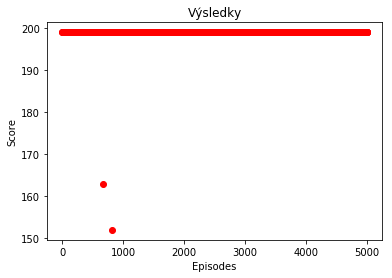

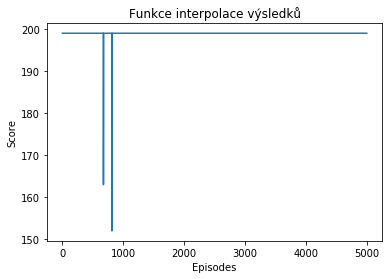

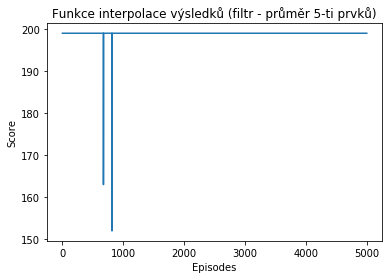

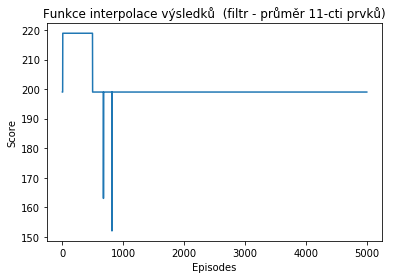

In [4]:
%matplotlib inline  
import matplotlib.pyplot as plt
import copy

score1 = copy.copy(scores)
score2 = copy.copy(scores)

for i in range (len(scores)):
    if i > 1 and i < 498:
        score1[i] = (scores[i - 2] + scores[i - 1] + scores[i] + scores[i + 1] + scores[i + 2])/5
        
for i in range (len(scores)):
    if i > 4 and i < 495:
        score2[i] += scores[i - 5] + scores[i - 4] + scores[i - 3] + scores[i - 2] + scores[i - 1]
        score2[i] += scores[i + 5] + scores[i + 4] + scores[i + 3] + scores[i + 2] + scores[i + 1]
        score2[i] = score2[i]/10
        
plt.plot(episodesList, scores, 'ro')
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Výsledky")
plt.show()

plt.plot(scores)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Funkce interpolace výsledků")
plt.show()

plt.plot(score1)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Funkce interpolace výsledků (filtr - průměr 5-ti prvků)")
plt.show()

plt.plot(score2)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Funkce interpolace výsledků  (filtr - průměr 11-cti prvků)")
plt.show()